### Load Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

### Setting

In [16]:
# Path
DATA_IN_PATH = './nlp_kor/data_in/'
DATA_OUT_PATH = './nlp_kor/data_out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

# Random Seed
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

# Hyperparameter
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 64
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
         'vocab_size' : prepro_configs['vocab_size'],
         'embedding_size' : 128,
         'num_filters' : 100,
         'dropout_rate' : 0.5,
         'hidden_dimension' : 250,
         'output_dimension' : 1}

### Load Data File

In [17]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

#### Declare Model

In [18]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                          output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                       kernel_size=kernel_size,
                                       padding='valid',
                                       activation=tf.keras.activations.relu,
                                       kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                          for kernel_size in [3, 4, 5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                                activation=tf.keras.activations.relu,
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                                activation=tf.keras.activations.sigmoid,
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [19]:
model = CNNClassifier(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy(name='accuracy'))

In [20]:
# Early Stopping
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder creating completed \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./nlp_kor/data_out/cnn_classifier_kr -- Folder creating completed 



#### Training Model

In [23]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, 
                    callbacks=[earlystop_callback,cp_callback])

Epoch 1/10
2110/2110 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.7962
Epoch 1: val_accuracy improved from -inf to 0.82620, saving model to ./nlp_kor/data_out/cnn_classifier_kr\weights.h5
2110/2110 [==============================] - 147s 69ms/step - loss: 0.4279 - accuracy: 0.7962 - val_loss: 0.3824 - val_accuracy: 0.8262
Epoch 2/10
2110/2110 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.8520
Epoch 2: val_accuracy improved from 0.82620 to 0.82873, saving model to ./nlp_kor/data_out/cnn_classifier_kr\weights.h5
2110/2110 [==============================] - 144s 68ms/step - loss: 0.3360 - accuracy: 0.8520 - val_loss: 0.3796 - val_accuracy: 0.8287
Epoch 3/10
2110/2110 [==============================] - ETA: 0s - loss: 0.2812 - accuracy: 0.8810
Epoch 3: val_accuracy did not improve from 0.82873
2110/2110 [==============================] - 141s 67ms/step - loss: 0.2812 - accuracy: 0.8810 - val_loss: 0.4066 - val_accuracy: 0.8283
Epoch 4/10

#### Visualizing with Graph

In [26]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

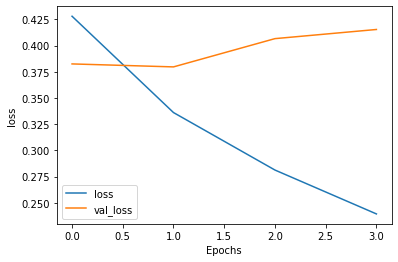

In [27]:
plot_graphs(history, 'loss')

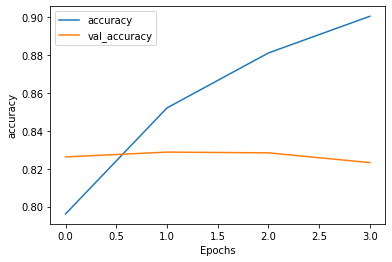

In [28]:
plot_graphs(history, 'accuracy')

#### Performance Validation

In [30]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NAME = 'weights.h5' # 저장된 best 모델명

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA , 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA , 'rb'))

In [31]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NAME))

In [32]:
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 3s 2ms/step - loss: 0.3864 - accuracy: 0.8266


[0.3863730728626251, 0.8266000151634216]